# 4. Домашнее задание
***

## Подготовка данных

In [1]:
import numpy as np
import pandas as pd
import math
import missingno as msno
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set2')

In [2]:
# df_kiva_loans = pd.read_csv("D:/files/1-15-kiva/kiva_loans.csv")
# df_mpi = pd.read_csv("D:/files/1-15-kiva/kiva_mpi_region_locations.csv")
df_kiva_loans = pd.read_csv("/home/user/PycharmProjects/files/1-15-kiva/kiva_loans.csv")
df_mpi = pd.read_csv("/home/user/PycharmProjects/files/1-15-kiva/kiva_mpi_region_locations.csv")

In [3]:
countries = df_kiva_loans['country'].value_counts()[df_kiva_loans['country'].value_counts(normalize=True)> 0.005]
list_countries = list(countries.index)
df_mpi_grouped = df_mpi\
    .groupby(['ISO', 'country', 'world_region'])['MPI']\
    .mean()\
    .fillna(0)\
    .reset_index()
df_kiva_loans = df_kiva_loans.merge(df_mpi_grouped, how='left', on='country')
# regions = df_kiva_loans['world_region'].value_counts()
# regions_list = regions.index.to_list()
df_kiva_loans['borrower_genders'] = [elem if elem in ['female','male'] else 'group' for elem in df_kiva_loans['borrower_genders'] ]


In [4]:
df_gender_by_country = \
    df_kiva_loans[df_kiva_loans['country'].isin(countries.index.values)]\
    .groupby(['country', 'borrower_genders'])['borrower_genders']\
    .count()\
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())\
    .unstack('borrower_genders')\
    .fillna(0)\

df_gender_by_country = df_gender_by_country[['male', 'group', 'female' ]]

# Наблюдаемое отклонение от среднего
dev = (df_kiva_loans['loan_amount']-df_kiva_loans['loan_amount'].mean()).abs()
# Стандартное отклонение
std = df_kiva_loans['loan_amount'].std()
# Фильтруем исходный набор данных
df_kiva_loans_trimmed = df_kiva_loans[~(dev>3*std)]

In [5]:
# drop na (missing) values
df_loans_dates = df_kiva_loans_trimmed.dropna(subset=['disbursed_time', 'funded_time'], how='any', inplace=False)

# dates columns:
dates = ['posted_time','disbursed_time']

# format dates:
df_loans_dates[dates] = df_loans_dates[dates].applymap(lambda x : x.split('+')[0])
df_loans_dates[dates] = df_loans_dates[dates].apply(pd.to_datetime)

# calculate time interval
df_loans_dates.loc[:, 'time_funding'] = df_loans_dates['disbursed_time']-df_loans_dates['posted_time']
df_loans_dates.loc[:, 'time_funding'] = df_loans_dates['time_funding'] / timedelta(days=1)

# remove outliers +-3 sigma
dev = (df_loans_dates['time_funding']-df_loans_dates['time_funding'].mean()).abs()
std = df_loans_dates['time_funding'].std()
# Keep rows where time_funding interval > 0 only
df_loans_dates_trimmed = df_loans_dates[~(dev>3*std) & (df_loans_dates.loc[:, 'time_funding']>0)]

/home/user/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/home/user/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/user/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

## 4.1. Самостоятельная работа
***
- А в каких странах преобладают мужчины? Группа людей? (п. 2.2.2.)
- Изучите несколько займов с очень большими суммами. Что можно сказать о назначении этих заявок? В каких странах они оформлены? Каков гендерный состав заявителей? (п. 2.4.2.)
- Попробуйте найти связь между странами (регионами), полом заёмщика и суммой заявки. Какие выводы можно сделать из этих данных? (п. 2.4.3.)

## В каких странах преобладают мужчины? Группа людей? (п. 2.2.2.)

In [5]:
print('Страны где преобладают мужчины:')
df_gender_by_country[(df_gender_by_country.male > df_gender_by_country.female) &
                     (df_gender_by_country.male > df_gender_by_country.group)
]\
    .sort_values(by='male', ascending=False)

Страны где преобладают мужчины:


borrower_genders,male,group,female
country,,,
Nigeria,87.134964,0.878058,11.986977
Palestine,64.601445,0.183666,35.214889
Uganda,48.701519,11.421776,39.876705
Mexico,34.767462,30.743773,34.488765


In [6]:
print('Страны где преобладают группы:')
df_gender_by_country[(df_gender_by_country.group> df_gender_by_country.female) &
                     (df_gender_by_country.group> df_gender_by_country.male)
]\
    .sort_values(by='group', ascending=False)

Страны где преобладают группы:


borrower_genders,male,group,female
country,,,
Mali,4.835066,91.836120,3.328815
Cambodia,5.368010,73.682398,20.949592
Guatemala,20.314637,62.640219,17.045144
Tanzania,10.346810,59.149262,30.503928
Ghana,16.095107,57.933242,25.971651
Paraguay,19.129631,55.053348,25.817021
Rwanda,22.865627,42.746845,34.387528


## Изучите несколько займов с очень большими суммами. Что можно сказать о назначении этих заявок? В каких странах они оформлены? Каков гендерный состав заявителей? (п. 2.4.2.)

In [6]:
df_high_loan = df_kiva_loans[df_kiva_loans.loan_amount >= 50000]

Большими займами будем считать, те займы, сумма которых больше 50000:

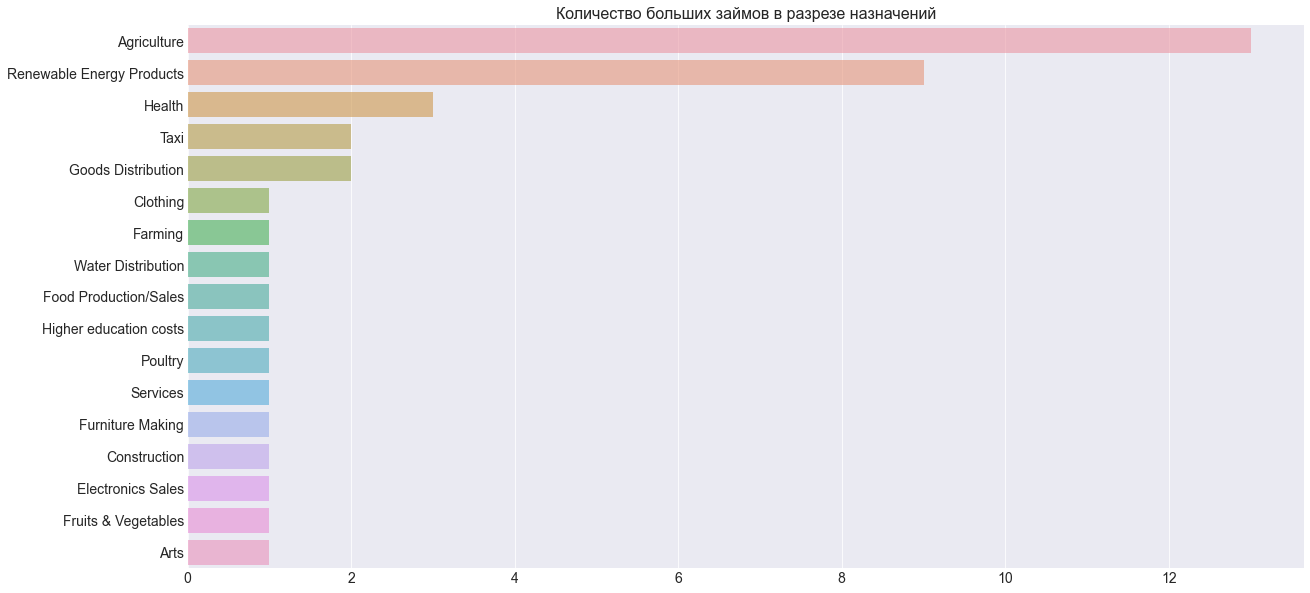

,sector,use,max_loan
0,Agriculture,create more than 300 jobs for women and farmer...,100000.0
1,Agriculture,To pay smallholder coffee farmers in rural Ken...,50000.0
2,Retail,to distribute 400 pay-as-you-go solar systems ...,50000.0
3,Health,to provide community trauma services in South ...,50000.0
4,Manufacturing,create jobs through environmentally-friendly m...,50000.0
5,Retail,To buy and sell Barefoot Power solar lighting.,50000.0
6,Retail,To buy and sell Barefoot Power's solar lightin...,50000.0
7,Retail,to buy and sell Barefoot Power's Solar Lightin...,50000.0
8,Retail,to distribute 200+ innovative & affordable pay...,50000.0
9,Retail,to distribute 400 pay-as-you-go solar home sys...,50000.0


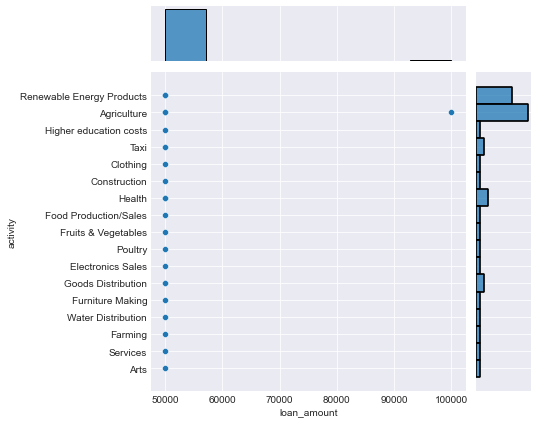

In [8]:
high_loan_activity = df_high_loan['activity'].value_counts()

plt.figure(figsize=(20,10))
plt.title("Количество больших займов в разрезе назначений", fontsize=16)
plt.tick_params(labelsize=14)
sns.barplot(y=high_loan_activity.index, x=high_loan_activity.values, alpha=0.6)
plt.show()

sns.jointplot(x='loan_amount', y='activity', data=df_high_loan , kind='scatter')

df_high_loan.groupby(['sector', 'use'])['loan_amount']\
    .agg(max_loan = 'max')\
    .sort_values('max_loan', ascending=False)\
    .reset_index()[:10]



Страны в которых эти займы были оформлены:

In [9]:
df_high_loan['country'].value_counts()

Kenya            7
Peru             4
Mexico           4
Ghana            4
Uganda           3
Haiti            3
Tanzania         2
Mozambique       1
Cote D'Ivoire    1
Madagascar       1
Guatemala        1
Pakistan         1
South Sudan      1
Malawi           1
Albania          1
Rwanda           1
Benin            1
Zambia           1
Indonesia        1
Ecuador          1
Zimbabwe         1
Name: country, dtype: int64

Гендерный состав заявителей:

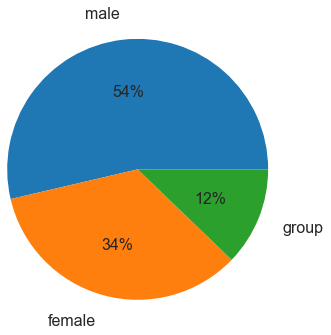

In [10]:
borrowers = df_high_loan['borrower_genders'].value_counts()
plot = borrowers.plot.pie(fontsize=16, autopct='%1.0f%%', labeldistance=1.2, radius=1.5)

## Попробуйте найти связь между странами (регионами), полом заёмщика и суммой заявки. Какие выводы можно сделать из этих данных? (п. 2.4.3.)

In [7]:
df_loan_gender = df_kiva_loans.groupby(['world_region', 'borrower_genders'])['loan_amount']\
    .agg(median_loan = 'median')\
    .sort_values('median_loan', ascending=False)\
    .reset_index()

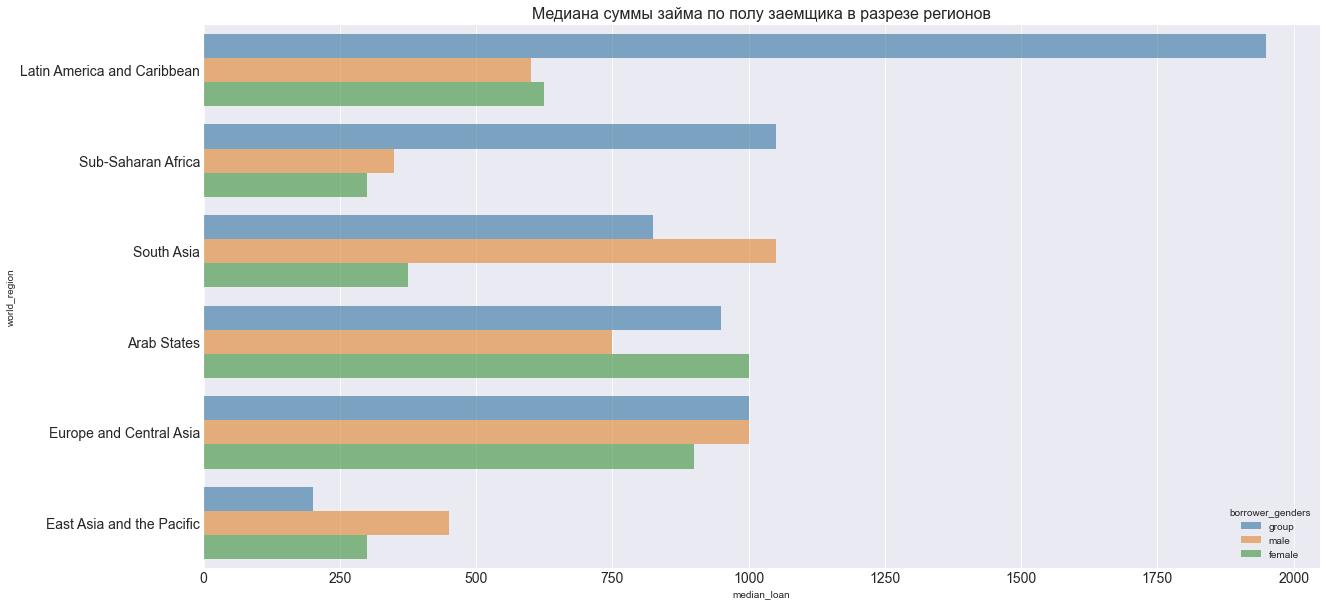

In [12]:
plt.figure(figsize=(20,10))
plt.title("Медиана суммы займа по полу заемщика в разрезе регионов", fontsize=16)
plt.tick_params(labelsize=14)
sns.barplot(data=df_loan_gender , y='world_region', x='median_loan', hue='borrower_genders', alpha=0.6)
plt.show()

# Домашняя работа
***
Расширьте наш отчёт исследованием следующих вопросов:

- Зависимость пола заёмщика от региона планеты, сектора экономики.
- Влияние такого атрибута займа, как **Количество кредиторов** (lender_count), на суммы и сроки займов.
- Влияние показателя **MPI** (многомерный индекс бедности) в разных странах на суммы займов и сроки погашения.
- Зависимости таких метрик, как «Сумма займа», «Срок займа», «Время финансирования заявки», «Ежемесячный платёж», в разрезе **макрорегионов**.

## Зависимость пола заёмщика от региона планеты, сектора экономики.

In [8]:
df_gender_by_region = \
    df_kiva_loans\
    .groupby(['world_region', 'borrower_genders'])['borrower_genders']\
    .count()\
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())\
    .unstack('borrower_genders')\
    .fillna(0)
    # .sort_values(by=['female', 'male'])[-20:]

df_gender_by_region = df_gender_by_region[['female', 'male', 'group']]

df_gender_by_sector = \
    df_kiva_loans\
    .groupby(['sector', 'borrower_genders'])['borrower_genders']\
    .count()\
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())\
    .unstack('borrower_genders')\
    .fillna(0)

df_gender_by_sector = df_gender_by_sector[['female', 'male', 'group']]

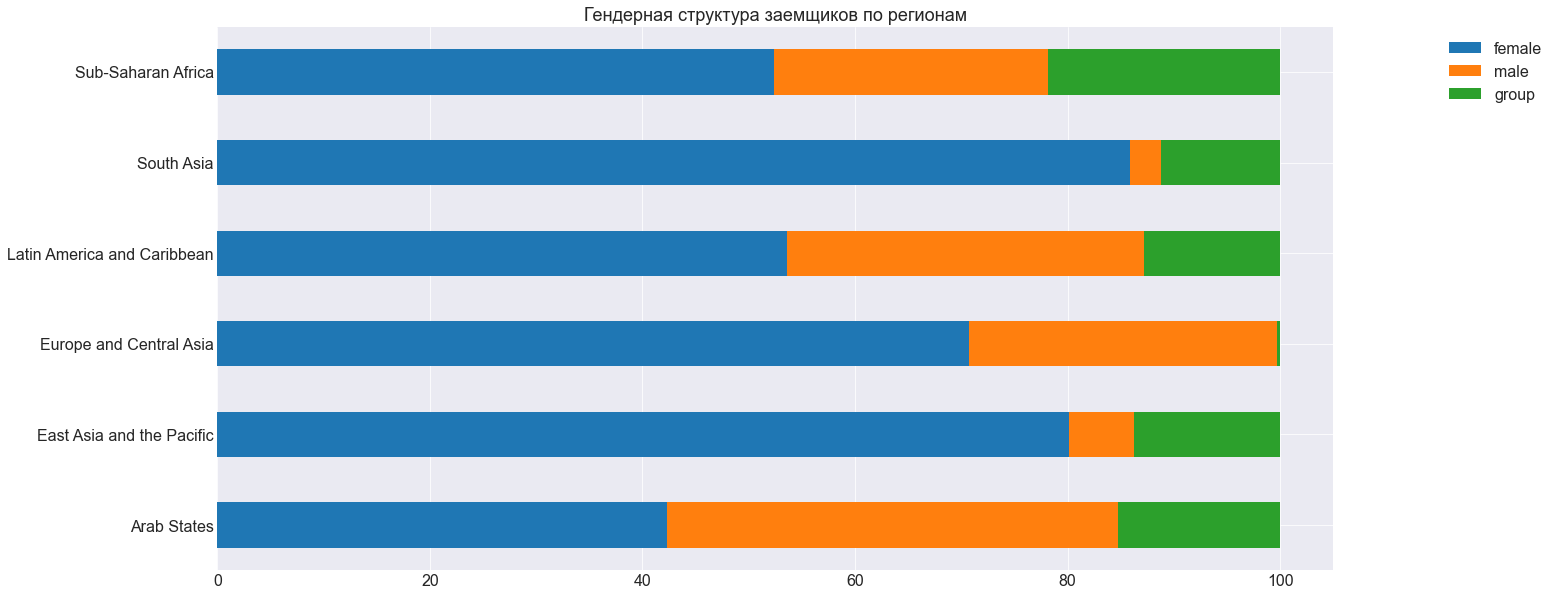

In [14]:
plot = df_gender_by_region.plot.barh(
        figsize=(20,10)
        , fontsize=16
        , stacked=True
        , title='Гендерная структура заемщиков по регионам')
plot.title.set_size(18)
plot.legend(loc=1, bbox_to_anchor=(1.2, 1), fontsize=16)
plot.set(ylabel=None, xlabel=None)
plt.show()

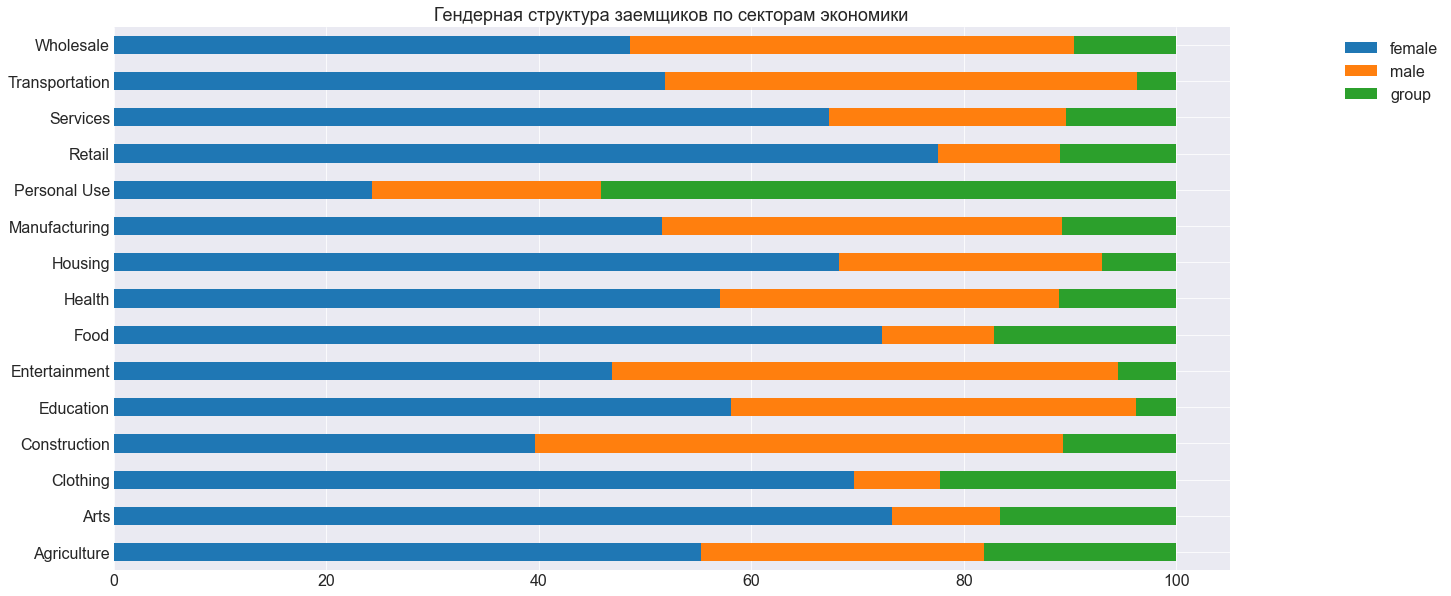

In [15]:
plot = df_gender_by_sector.plot.barh(
        figsize=(20,10)
        , fontsize=16
        , stacked=True
        , title='Гендерная структура заемщиков по секторам экономики')
plot.title.set_size(18)
plot.legend(loc=1, bbox_to_anchor=(1.2, 1), fontsize=16)
plot.set(ylabel=None, xlabel=None)
plt.show()

## Влияние такого атрибута займа, как **Количество кредиторов** (lender_count), на суммы и сроки займов.

In [ ]:
# sns.jointplot(x="lender_count", y="loan_amount", data=df_kiva_loans, kind='kde', height=10, ratio=7, xlim=[0,40] , ylim=[0,2200])\
#     .set_axis_labels("Количество дней", "Сумма займа", size=18)
sns.jointplot(x='lender_count', y='loan_amount', data=df_kiva_loans_trimmed, kind='reg');

In [ ]:
p = sns.jointplot(x='lender_count', y='loan_amount', data=df_kiva_loans_trimmed, kind='kde', height=10, ratio=7)\
    .set_axis_labels('Количество кредиторов', 'Сумма займа', size=18)
p.ax_joint.tick_params(labelsize=14)
plt.show()

In [ ]:
sns.jointplot(x='lender_count', y='term_in_months', data=df_kiva_loans_trimmed, kind='reg');

In [ ]:
p = sns.jointplot(x='lender_count', y='term_in_months', data=df_kiva_loans_trimmed, kind='kde', height=10, ratio=7)\
    .set_axis_labels('Количество кредиторов', 'Срок займа', size=18)
p.ax_joint.tick_params(labelsize=14)
plt.show()

## Влияние показателя **MPI** (многомерный индекс бедности) в разных странах на суммы займов и сроки погашения.

In [9]:
df_mpi_by_country = df_kiva_loans_trimmed[['country', 'world_region', 'MPI', 'loan_amount', 'term_in_months']]\
    .groupby(['country', 'MPI'])\
    .agg({'world_region': 'first', 'loan_amount' : 'median', 'term_in_months' : 'median'})\
    .reset_index()

regions = df_mpi['world_region'].dropna().unique()

df_mpi_by_country

,country,MPI,world_region,loan_amount,term_in_months
0,Albania,0.000000,Europe and Central Asia,1225.0,26.0
1,Armenia,0.000000,Europe and Central Asia,1475.0,26.0
2,Azerbaijan,0.000000,Europe and Central Asia,1450.0,15.0
3,Belize,0.020143,Latin America and Caribbean,625.0,26.0
4,Benin,0.320333,Sub-Saharan Africa,625.0,10.0
5,Brazil,0.027259,Latin America and Caribbean,1987.5,9.0
6,Burkina Faso,0.547692,Sub-Saharan Africa,975.0,8.0
7,Burundi,0.411800,Sub-Saharan Africa,2675.0,8.0
8,Cambodia,0.164053,East Asia and the Pacific,325.0,13.0
9,Cameroon,0.202833,Sub-Saharan Africa,375.0,15.0


In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title('Зависимость суммы займов от MPI, по странам', fontsize=24)
colors = [plt.cm.tab10(i/float(len(regions)-1)) for i in range(len(regions))]
for idx, region in enumerate(regions):
    df_mpi_by_country[df_mpi_by_country.world_region == region]\
        .plot.scatter(x='loan_amount', y='MPI', color=colors[idx], ax=ax, label=region)
ax.set_xlabel('Сумма займа', fontsize=22)
ax.set_ylabel('MPI', fontsize=22)
plt.show()


In [ ]:
sns.jointplot(x='loan_amount', y='MPI', data=df_mpi_by_country, kind='reg', size=10)\
    .set_axis_labels('Сумма займа',"MPI", fontsize=20)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title('Зависимость срока займа от MPI, по странам', fontsize=24)
colors = [plt.cm.tab10(i/float(len(regions)-1)) for i in range(len(regions))]
for idx, region in enumerate(regions):
    df_mpi_by_country[df_mpi_by_country.world_region == region]\
        .plot.scatter(x='term_in_months', y='MPI', color=colors[idx], ax=ax, label=region)
ax.set_xlabel('Срок займа (в месяцах)', fontsize=22)
ax.set_ylabel('MPI', fontsize=22)
plt.show()

In [ ]:
sns.jointplot(x='term_in_months', y='MPI', data=df_mpi_by_country, kind='reg', size=10)\
    .set_axis_labels('Срок займа',"MPI", fontsize=20)
plt.show()

## Зависимости таких метрик, как «Сумма займа», «Срок займа», «Время финансирования заявки», «Ежемесячный платёж», в разрезе **макрорегионов**.

In [10]:
df_regions_median = df_loans_dates_trimmed.groupby(['world_region'])\
    .agg({'loan_amount' : 'median', 'time_funding' : 'median', 'term_in_months' : 'median'})\
    .reset_index()

df_regions_median['monthly_repayment'] = df_regions_median['loan_amount'] / df_regions_median['term_in_months']

In [ ]:
plt.figure(figsize=(10,8), dpi= 80)
p = sns.pairplot(df_regions_median, kind="reg", hue="world_region")
plt.show()

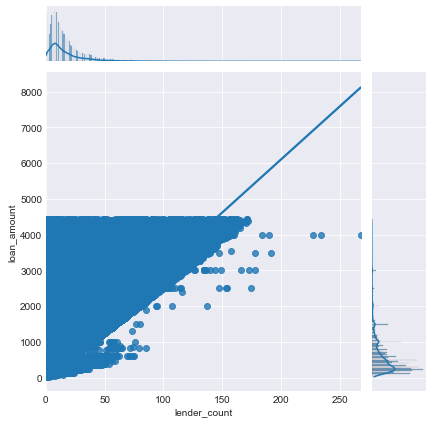

In [16]:
plt.figure(figsize=(10,8), dpi= 80)
p = sns.pairplot(df_regions_median, kind="reg", hue="world_region")
plt.show()

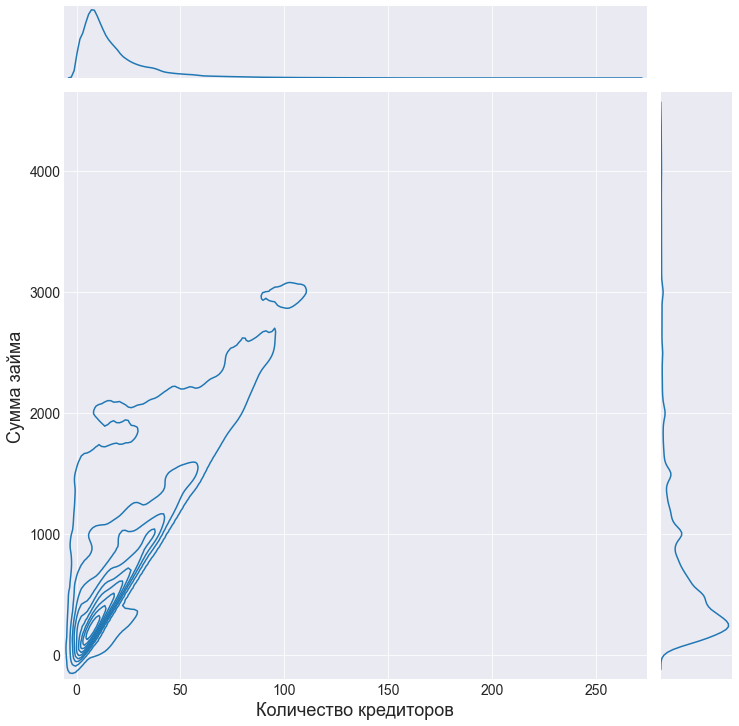

In [24]:
p = sns.jointplot(x='lender_count', y='loan_amount', data=df_kiva_loans_trimmed, kind='kde', height=10, ratio=7)\
    .set_axis_labels('Количество кредиторов', 'Сумма займа', size=18)
p.ax_joint.tick_params(labelsize=14)
plt.show()

In [ ]:
sns.jointplot(x='lender_count', y='term_in_months', data=df_kiva_loans_trimmed, kind='reg');

In [ ]:
p = sns.jointplot(x='lender_count', y='term_in_months', data=df_kiva_loans_trimmed, kind='kde', height=10, ratio=7)\
    .set_axis_labels('Количество кредиторов', 'Срок займа', size=18)
p.ax_joint.tick_params(labelsize=14)
plt.show()

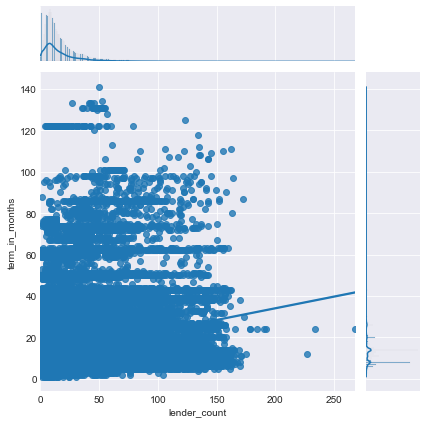

In [27]:
- Влияние показателя **MPI** (многомерный индекс бедности) в разных странах на суммы займов и сроки погашения.

In [11]:
df_mpi_by_country = df_kiva_loans_trimmed[['country', 'world_region', 'MPI', 'loan_amount', 'term_in_months']]\
    .groupby(['country', 'MPI'])\
    .agg({'world_region': 'first', 'loan_amount' : 'median', 'term_in_months' : 'median'})\
    .reset_index()

regions = df_mpi['world_region'].dropna().unique()

df_mpi_by_country

,country,MPI,world_region,loan_amount,term_in_months
0,Albania,0.000000,Europe and Central Asia,1225.0,26.0
1,Armenia,0.000000,Europe and Central Asia,1475.0,26.0
2,Azerbaijan,0.000000,Europe and Central Asia,1450.0,15.0
3,Belize,0.020143,Latin America and Caribbean,625.0,26.0
4,Benin,0.320333,Sub-Saharan Africa,625.0,10.0
5,Brazil,0.027259,Latin America and Caribbean,1987.5,9.0
6,Burkina Faso,0.547692,Sub-Saharan Africa,975.0,8.0
7,Burundi,0.411800,Sub-Saharan Africa,2675.0,8.0
8,Cambodia,0.164053,East Asia and the Pacific,325.0,13.0
9,Cameroon,0.202833,Sub-Saharan Africa,375.0,15.0


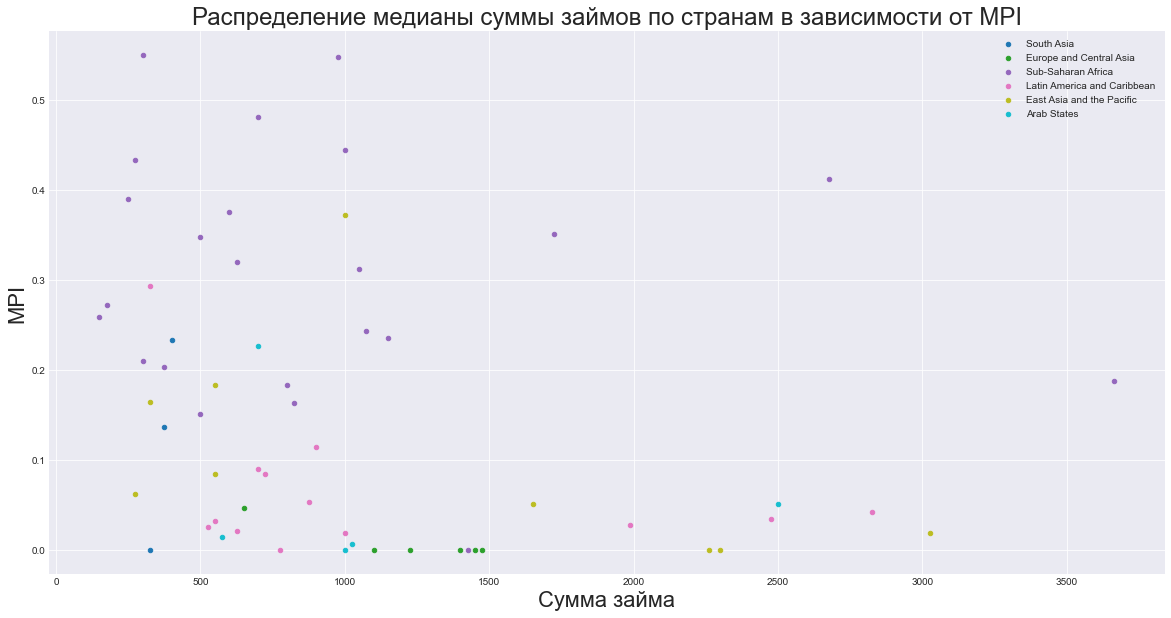

In [45]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title('Зависимость суммы займов от MPI, по странам', fontsize=24)
colors = [plt.cm.tab10(i/float(len(regions)-1)) for i in range(len(regions))]
for idx, region in enumerate(regions):
    df_mpi_by_country[df_mpi_by_country.world_region == region]\
        .plot.scatter(x='loan_amount', y='MPI', color=colors[idx], ax=ax, label=region)
ax.set_xlabel('Сумма займа', fontsize=22)
ax.set_ylabel('MPI', fontsize=22)
plt.show()


c:\users\user\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\axisgrid.py:2015: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


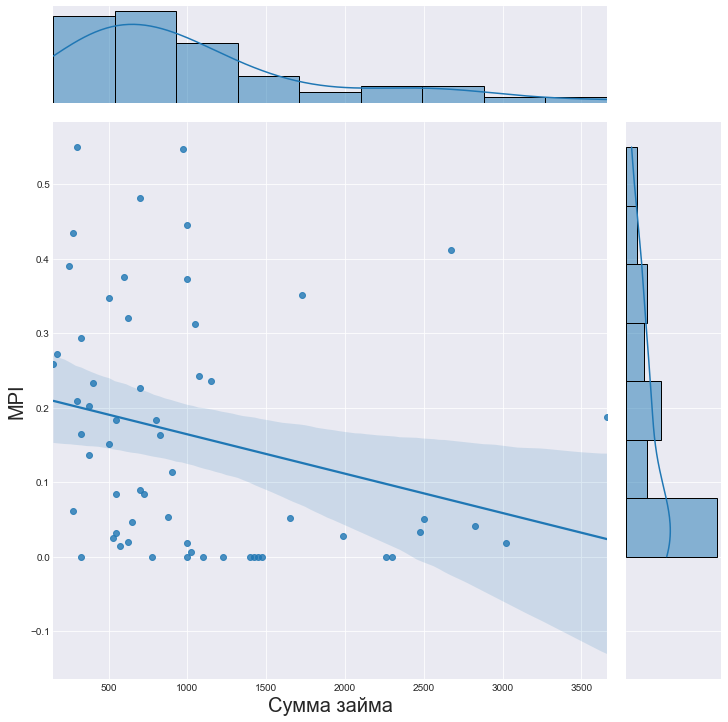

In [60]:
sns.jointplot(x='loan_amount', y='MPI', data=df_mpi_by_country, kind='reg', size=10)\
    .set_axis_labels('Сумма займа',"MPI", fontsize=20)
plt.show()

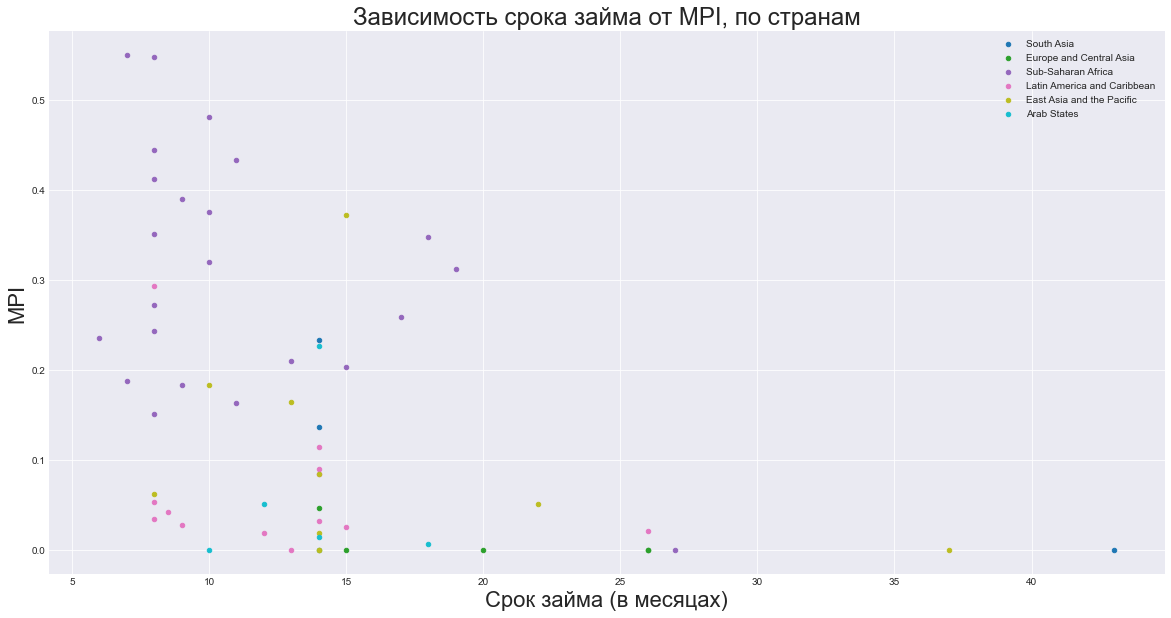

In [62]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title('Зависимость срока займа от MPI, по странам', fontsize=24)
colors = [plt.cm.tab10(i/float(len(regions)-1)) for i in range(len(regions))]
for idx, region in enumerate(regions):
    df_mpi_by_country[df_mpi_by_country.world_region == region]\
        .plot.scatter(x='term_in_months', y='MPI', color=colors[idx], ax=ax, label=region)
ax.set_xlabel('Срок займа (в месяцах)', fontsize=22)
ax.set_ylabel('MPI', fontsize=22)
plt.show()

c:\users\user\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\axisgrid.py:2015: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


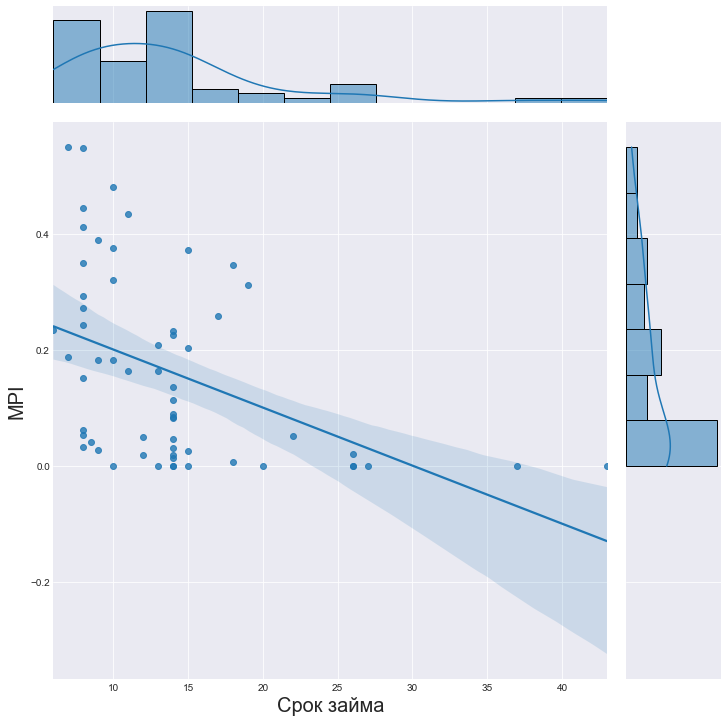

In [61]:
sns.jointplot(x='term_in_months', y='MPI', data=df_mpi_by_country, kind='reg', size=10)\
    .set_axis_labels('Срок займа',"MPI", fontsize=20)
plt.show()

In [12]:
df_regions_median = df_loans_dates_trimmed.groupby(['world_region'])\
    .agg({'loan_amount' : 'median', 'time_funding' : 'median', 'term_in_months' : 'median'})\
    .reset_index()

df_regions_median['monthly_repayment'] = df_regions_median['loan_amount'] / df_regions_median['term_in_months']

c:\users\user\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\user\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\user\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\user\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\user\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, Use

<Figure size 800x640 with 0 Axes>

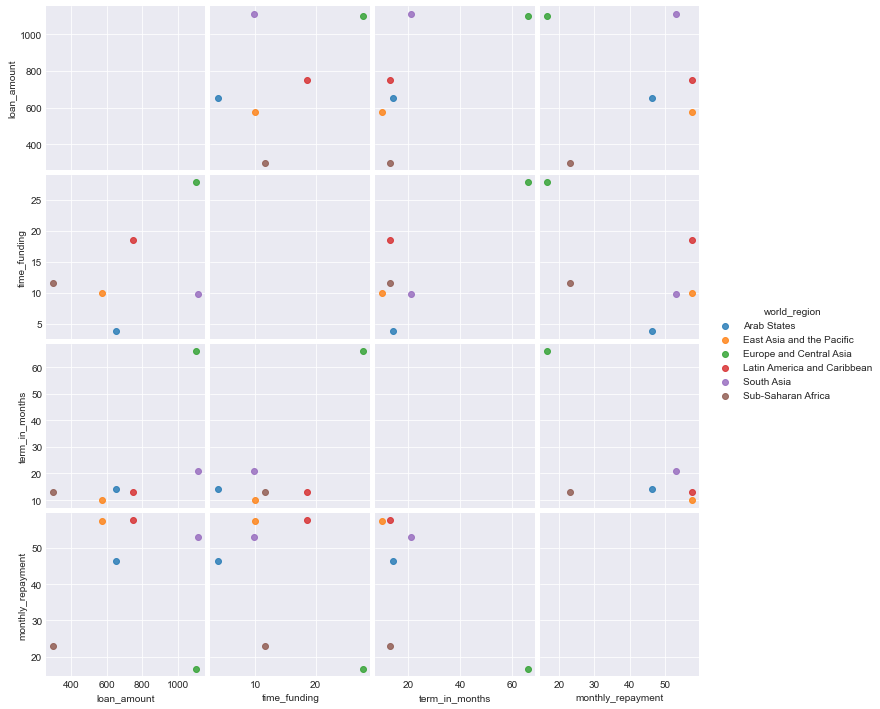

In [21]:
plt.figure(figsize=(10,8), dpi= 80)
p = sns.pairplot(df_regions_median, kind="reg", hue="world_region")
plt.show()